### Assignment 1. Given the Citeseer graph in Pytorch Geometric as shown in the following:
(https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html#torch_geometric.datasets.Planetoid)

Questions:

1) Show some graph statistics of the Citeseer graph (Number of nodes, Number of edges, and node feature length, ...)
2) Running the GraphSage model on Node classification on the Citeseer graph

In [7]:
import torch
import os.path as osp
from torch_geometric.datasets import Planetoid

# Define the path to the dataset directory
path = osp.join('data', 'Citeseer')

# Load the Cora dataset using the Planetoid class
dataset = Planetoid(path, name='Citeseer')
data = dataset[0]

# Extract node features, edge index, and labels
node_features = data.x  # (number_of_nodes, number_of_features)
edge_index = data.edge_index  # (2, number_of_edges)
labels = data.y  # (number_of_nodes,)

print(f"Node Features Shape: {node_features.shape}")
print(f"Edge Index Shape: {edge_index.shape}")
print(f"Labels Shape: {labels.shape}")

Node Features Shape: torch.Size([3327, 3703])
Edge Index Shape: torch.Size([2, 9104])
Labels Shape: torch.Size([3327])


In [8]:
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node feature dimension: {data.num_node_features}")

Number of nodes: 3327
Number of edges: 9104
Node feature dimension: 3703


In [9]:
from collections import defaultdict
import numpy as np

# Create adjacency list from edge_index
def build_adj_list(edge_index):
    adj_list = defaultdict(list)
    for i, j in edge_index.t().tolist():
        adj_list[i].append(j)
        adj_list[j].append(i)  # Since it's an undirected graph
    return adj_list

adj_list = build_adj_list(edge_index)

# Convert node features to a dictionary
node_features_dict = {i: node_features[i].numpy() for i in range(node_features.shape[0])}

# Check adjacency list and node features
print("Adjacency List Example (Node 0):", adj_list[0])
print("Node Features Example (Node 0):", node_features_dict[0])

Adjacency List Example (Node 0): [628, 628]
Node Features Example (Node 0): [0. 0. 0. ... 0. 0. 0.]


In [10]:
import random

def sample_neighbors(adj_list, node, sample_size):
    """Sample neighbors of a node randomly."""
    neighbors = adj_list.get(node, [])  # Get neighbors or empty list if node has no neighbors
    if len(neighbors) == 0:
        return []  # No neighbors, return empty list
    elif len(neighbors) <= sample_size:
        return neighbors  # Return all neighbors if fewer than sample size
    else:
        return random.sample(neighbors, sample_size)  # Randomly sample neighbors without replacement

# Example: Sample neighbors for node 0
sampled_neighbors = sample_neighbors(adj_list, 0, sample_size=5)
print("Sampled Neighbors for Node 0:", sampled_neighbors)

Sampled Neighbors for Node 0: [628, 628]


In [11]:
def aggregate_features(node, sampled_neighbors, node_features_dict):
    if len(sampled_neighbors) == 0:
        return np.zeros_like(node_features_dict[node])
    neighbor_features = np.array([node_features_dict[neighbor] for neighbor in sampled_neighbors])
    aggregated_features = np.mean(neighbor_features, axis=0)
    return aggregated_features

# Example: Aggregate features for node 0
aggregated_features_0 = aggregate_features(0, sampled_neighbors, node_features_dict)
print("Aggregated Features for Node 0:", aggregated_features_0)

Aggregated Features for Node 0: [0. 0. 0. ... 0. 0. 0.]


In [12]:
def update_node_representation(node, aggregated_features, node_features_dict, weight_matrix):
    # Get the node's feature vector
    node_feature = node_features_dict[node]

    # Concatenate the node's feature and the aggregated neighbor features
    concatenated_features = np.concatenate([node_feature, aggregated_features])  # Shape: (2 * input_dim,)

    # Perform matrix multiplication: weight_matrix * concatenated_features
    updated_representation = np.dot(weight_matrix, concatenated_features)  # weight_matrix shape: (input_dim, 2 * input_dim)

    return updated_representation

# Example: Initialize a weight matrix and update node representation for node 0
input_dim = node_features.shape[1]  # Cora feature dimension is 1433
weight_matrix = np.random.rand(input_dim, 2 * input_dim)  # Shape: (input_dim, 2 * input_dim)

# Assuming we already aggregated features for node 0 using the previous steps
updated_representation_0 = update_node_representation(0, aggregated_features_0, node_features_dict, weight_matrix)
print("Updated Representation for Node 0:", updated_representation_0)

Updated Representation for Node 0: [25.53318339 28.38081322 24.65238784 ... 28.22255807 26.44498208
 27.45840149]


In [13]:
def graphsage_layer(adj_list, node_features_dict, sample_size, weight_matrix):
    new_node_features_dict = {}
    for node in node_features_dict:
        sampled_neighbors = sample_neighbors(adj_list, node, sample_size)
        aggregated_features = aggregate_features(node, sampled_neighbors, node_features_dict)
        updated_representation = update_node_representation(node, aggregated_features, node_features_dict, weight_matrix)
        new_node_features_dict[node] = updated_representation
    return new_node_features_dict

# Example: Apply one layer of GraphSAGE
new_node_features_dict = graphsage_layer(adj_list, node_features_dict, sample_size=5, weight_matrix=weight_matrix)
print("New Node Representation for Node 0:", new_node_features_dict[0])

New Node Representation for Node 0: [25.53318339 28.38081322 24.65238784 ... 28.22255807 26.44498208
 27.45840149]


In [14]:
def multilayer_graphsage(adj_list, node_features_dict, num_layers, sample_size):
    """Apply multiple layers of GraphSAGE."""
    input_dim = len(next(iter(node_features_dict.values())))  # Get the feature dimension from any node
    current_node_features_dict = node_features_dict

    for layer in range(num_layers):
        # Correct weight matrix shape: (input_dim, 2 * input_dim)
        weight_matrix = np.random.rand(input_dim, 2 * input_dim)

        # Apply one GraphSAGE layer
        current_node_features_dict = graphsage_layer(adj_list, current_node_features_dict, sample_size, weight_matrix)

    return current_node_features_dict

# Example: Apply 2 layers of GraphSAGE
final_node_features_dict = multilayer_graphsage(adj_list, node_features_dict, num_layers=2, sample_size=5)

# Print the final representation of node 0 after 2 layers
print("Final Node Representation for Node 0 after 2 layers:", final_node_features_dict[0])

Final Node Representation for Node 0 after 2 layers: [100476.32616841 102208.34050868 102511.78623099 ... 101765.02268993
 100981.02814751 102918.10201381]


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Extract node features and labels based on the correct node IDs
node_ids = list(final_node_features_dict.keys())  # Get the list of node IDs from the final_node_features dict
X = np.array([final_node_features_dict[node] for node in node_ids])  # Extract the corresponding node features
y = np.array([labels[node] for node in node_ids])  # Extract the corresponding labels for these nodes

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression classifier
clf = LogisticRegression(solver='liblinear',max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 75.23%


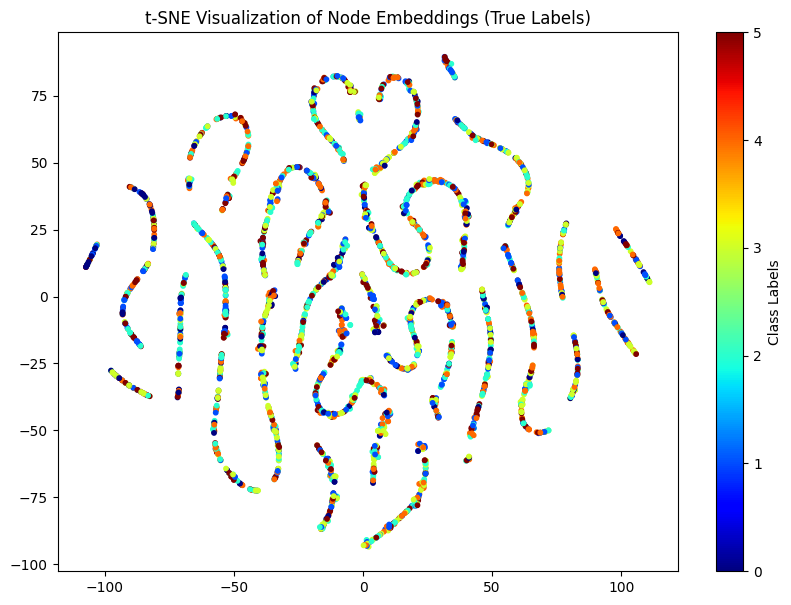

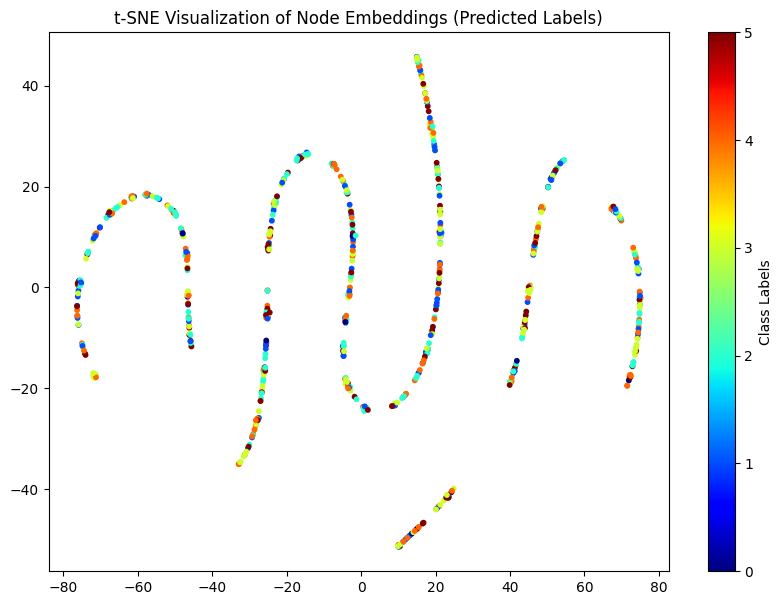

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions of node embeddings using t-SNE
def visualize_tsne(X, y, title, perplexity=10):
    """Visualize embeddings using t-SNE."""
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(perplexity, X.shape[0] - 1))
    X_tsne = tsne.fit_transform(X)

    # Plot t-SNE results
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='jet', s=10)
    plt.colorbar(scatter, label='Class Labels')
    plt.title(title)
    plt.show()

# Visualize node embeddings with true labels
visualize_tsne(X, y, "t-SNE Visualization of Node Embeddings (True Labels)")

# Visualize node embeddings with predicted labels
visualize_tsne(X_test, y_pred, "t-SNE Visualization of Node Embeddings (Predicted Labels)")

### Assignment 2. Load the Citeseer graph dataset from Torch Geometric and then do the node classification task by using the Cluster GCN model

In [17]:
import torch
import os.path as osp
from torch_geometric.datasets import Planetoid

# Define the path to the dataset directory
path = osp.join('data', 'Citeseer')

# Load the Cora dataset using the Planetoid class
dataset = Planetoid(path, name='Citeseer')
data = dataset[0]

# Extract node features, edge index, and labels
node_features = data.x  # (number_of_nodes, number_of_features)
edge_index = data.edge_index  # (2, number_of_edges)
labels = data.y  # (number_of_nodes,)

print(f"Node Features Shape: {node_features.shape}")
print(f"Edge Index Shape: {edge_index.shape}")
print(f"Labels Shape: {labels.shape}")

Node Features Shape: torch.Size([3327, 3703])
Edge Index Shape: torch.Size([2, 9104])
Labels Shape: torch.Size([3327])


In [18]:
import numpy as np
import torch
from scipy.sparse import csgraph
from sklearn.cluster import KMeans
from sklearn.manifold import SpectralEmbedding
from scipy.sparse.csgraph import connected_components

def build_clusters(edge_index, node_features, num_clusters):
    num_nodes = node_features.shape[0]

    # Step 1: Create adjacency matrix from edge_index
    adj_matrix = np.zeros((num_nodes, num_nodes))
    for edge in edge_index.T:
        adj_matrix[edge[0], edge[1]] = 1
        adj_matrix[edge[1], edge[0]] = 1  # Since it's undirected

    # Step 2: Check connected components
    num_components, labels = connected_components(csgraph=adj_matrix, directed=False, return_labels=True)

    # Initialize clusters
    clusters = []

    # Apply spectral clustering within each connected component
    for component in range(num_components):
        component_nodes = np.where(labels == component)[0]
        if len(component_nodes) < num_clusters:
            # If the component is too small, treat it as one cluster
            clusters.append(component_nodes)
        else:
            # Apply spectral clustering to this component
            sub_adj_matrix = adj_matrix[component_nodes][:, component_nodes]
            spectral_emb = SpectralEmbedding(n_components=num_clusters, affinity='precomputed')
            node_embeddings = spectral_emb.fit_transform(sub_adj_matrix)
            kmeans = KMeans(n_clusters=num_clusters)
            cluster_assignments = kmeans.fit_predict(node_embeddings)

            # Assign nodes to clusters
            for i in range(num_clusters):
                clusters.append(component_nodes[np.where(cluster_assignments == i)[0]])

    return clusters

In [19]:
def extract_subgraph(edge_index, cluster):
    mask = np.isin(edge_index[0].cpu().numpy(), cluster) & np.isin(edge_index[1].cpu().numpy(), cluster)
    sub_edge_index = edge_index[:, mask]
    node_map = {node: i for i, node in enumerate(cluster)}
    sub_edge_index = torch.tensor([[node_map[n.item()] for n in sub_edge_index[0]],
                                   [node_map[n.item()] for n in sub_edge_index[1]]], dtype=torch.long)
    return sub_edge_index

In [20]:
def construct_batch(clusters, edge_index, node_features, labels):
    batch_node_features = []
    batch_edge_index = []
    batch_labels = []
    for cluster in clusters:
        subgraph_edges = extract_subgraph(edge_index, cluster)
        subgraph_features = node_features[cluster]
        subgraph_labels = labels[cluster]
        batch_node_features.append(subgraph_features)
        batch_edge_index.append(subgraph_edges)
        batch_labels.append(subgraph_labels)
    return batch_node_features, batch_edge_index, batch_labels

In [21]:
class ClusterGCNLayer(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(ClusterGCNLayer, self).__init__()
        self.linear = torch.nn.Linear(in_features, out_features)

    def forward(self, node_features, edge_index):
        row, col = edge_index
        aggregate = torch.zeros_like(node_features)

        for i in range(len(row)):
            aggregate[row[i]] += node_features[col[i]]

        return self.linear(aggregate)

In [22]:
class ClusterGCN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(ClusterGCN, self).__init__()
        self.layer1 = ClusterGCNLayer(in_features, hidden_features)
        self.layer2 = ClusterGCNLayer(hidden_features, out_features)

    def forward(self, batch_node_features, batch_edge_index):
        # Process each cluster
        out = []
        for node_features, edge_index in zip(batch_node_features, batch_edge_index):
            x = self.layer1(node_features, edge_index)
            x = torch.relu(x)
            x = self.layer2(x, edge_index)
            out.append(x)

        return out

In [23]:
import torch.optim as optim
import torch.nn as nn

# Define number of clusters
num_clusters = 10
clusters = build_clusters(edge_index, node_features, num_clusters)
batch_node_features, batch_edge_index, batch_labels = construct_batch(clusters, edge_index, node_features, labels)

# Step 2: Train the ClusterGCN model
def train_cluster_gcn(batch_node_features, batch_edge_index, batch_labels):
    all_labels = torch.cat(batch_labels, dim=0)
    model = ClusterGCN(batch_node_features[0].shape[1], 16, len(torch.unique(all_labels)))
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(batch_node_features, batch_edge_index)
        all_outputs = torch.cat(outputs, dim=0)
        loss = loss_fn(all_outputs, all_labels)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

    return model

# Train the model
model = train_cluster_gcn(batch_node_features, batch_edge_index, batch_labels)

/home/user/anaconda3/envs/GNN2/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:372: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(
/home/user/anaconda3/envs/GNN2/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:372: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(
/home/user/anaconda3/envs/GNN2/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:372: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(


Epoch 10, Loss: 1.023088812828064
Epoch 20, Loss: 0.7193756699562073
Epoch 30, Loss: 0.4998520314693451
Epoch 40, Loss: 0.3482120931148529
Epoch 50, Loss: 0.25087642669677734


In [ ]:
def get_node_embeddings(model, batch_node_features, batch_edge_index):
    model.eval()
    embeddings = []
    with torch.no_grad():
        outputs = model(batch_node_features, batch_edge_index)
        embeddings = torch.cat(outputs, dim=0)
    return embeddings

# Get the trained node embeddings
node_embeddings = get_node_embeddings(model, batch_node_features, batch_edge_index)

node_embeddings = node_embeddings.cpu()

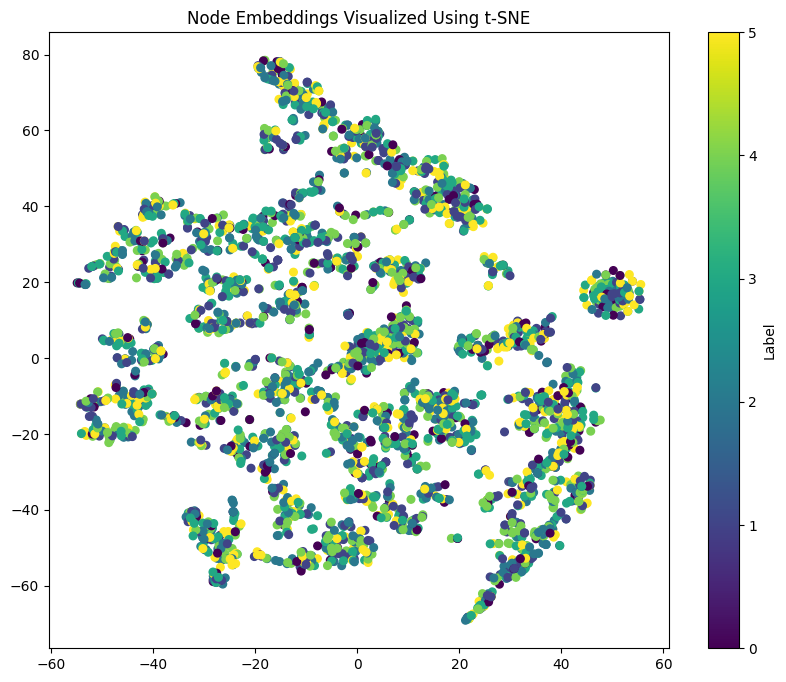

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Step 5: Plot the embeddings, coloring them by their true labels
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=labels.numpy(), cmap='viridis', s=30)
plt.colorbar(label="Label")
plt.title('Node Embeddings Visualized Using t-SNE')
plt.show()